Analyse campagne 2018
===========

Dans ce notebook on présente les résultats de notre projet tutoré blablabla

# Sommaire
* **[I. Analyse par textes](#I.-Analyse-par-texte)**
    * [I.1. Présentation graphique](#I.1.-Présentation-graphique)
    * [I.2.-Calcul-de-l'entropie](#I.2.-Calcul-de-l'entropie)
* **[II. Analyse par annotateur](#II.-Analyse-par-annotateur)**

In [1]:
# Customization du notebook pour que ce soit plus lisible et agréable à utiliser
%matplotlib inline
from IPython.core.display import display, HTML

# Augmentation de la largeur de la fenêtre
display(HTML("<style>.container { width:95% !important; }</style>"))

# On fait en sorte qu'il n'y ai pas d'ascenseur vertical pour les images générées
display(HTML("<script>IPython.OutputArea.prototype._should_scroll=function(){return false;}</script>"))

#On cache le code
display(HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Afficher/Cacher le code"></form>'''))

import warnings
warnings.filterwarnings('ignore')

In [2]:
from ipywidgets import interact, fixed, FloatSlider, interactive, Button

from os import path

import pandas

from scipy import stats

import matplotlib.pyplot as plt

import operator

from data import Unit, Texte, Campagne, Annotateur, Relation, Annotation, Theme
from parsing2 import parsing
from analyse import *

In [3]:
## Récupérations des données

AnnotationDirectory = "Campagne 2018"
projectDirectory = "../"
textsNames = ["Bac_a_sable", "Florence","Provocation", "Nord", "Concours", "Sauveur", "Volley"]
textDirectories = [path.join(projectDirectory,AnnotationDirectory,t) for t in textsNames]

print("Lecture des fichiers de la campagne...")

camp = parsing(textDirectories)

typesRel = {"Narration":"horizontale", "Réponse":"horizontale", "Elaboration descriptive":"verticale", "Elaboration evaluative":"verticale", "Elaboration prescriptive":"verticale", "Conduite":"verticale","Phatique":"verticale","Contre-élaboration":"verticale","Méta-question":"verticale","Question":"verticale"}
camp.typesRelations = typesRel

nAnnots = 0
for t in textsNames:
    nAnnots += len(camp.getAnnotations(t))
print(nAnnots, "annotations ont été chargées.")

mauvaisesAnnots = supprimerMauvaisesAnnotations(camp)
if len(mauvaisesAnnots) > 0:
    print("\nLes annotations suivantes étaient non conformes et ne seront pas prises en compte :")
    print(mauvaisesAnnots)

Lecture des fichiers de la campagne...
155 annotations ont été chargées.

Les annotations suivantes étaient non conformes et ne seront pas prises en compte :
[('A06', 'Concours'), ('C02', 'Bac_a_sable'), ('C07', 'Florence'), ('C10', 'Provocation'), ('C10', 'Concours'), ('E01', 'Bac_a_sable'), ('E04', 'Sauveur'), ('E06', 'Florence'), ('E10', 'Volley'), ('E11', 'Nord')]


# I. Analyse par textes

## I.1. Présentation graphique

In [4]:
# En utilisant juste la fonction interact on ne peut pas récupérer l'objet retourné par la fonction alors on va utiliser interactive. 
# Mais pour ça il faut écrire directement dans la fonction qu'on lui passe ce qu'on veut qu'il affiche (il n'affiche pas automatiquement le return) donc on va encapsuler la fonction de dessin ici
def drawing_tree_wrapper(nomTexte, regroupement, seuilAffichage=0.1, montrerThemes=True):
    dot = draw_global_tree(camp, nomTexte, regroupement, seuilAffichage, montrerThemes)
    display(dot)
    return(dot)

global_tree = interactive(drawing_tree_wrapper, nomTexte=textsNames, regroupement=["aucun", "catégorie", "emplacement"], seuilAffichage=FloatSlider(min=0.,max=1., step=0.05, value=0.1, continuous_update=False))

bEnregistrerGraphe = Button(
    description='Enregistrer',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Enregistrer ce graphe',
    icon='download'
)

def enregistrer(b):
    nom_fichier = global_tree.kwargs['nomTexte'] + "_-_" + global_tree.kwargs['regroupement'] + "_-_" + str(global_tree.kwargs['seuilAffichage'])
    dot = global_tree.result
    #dot.format = 'svg'
    dot.render(filename=nom_fichier, directory="images_enregistrees", view=True)
    
bEnregistrerGraphe.on_click(enregistrer)

In [5]:
display(global_tree)
display(bEnregistrerGraphe)

interactive(children=(Dropdown(description='nomTexte', options=('Bac_a_sable', 'Florence', 'Provocation', 'Nor…

Button(description='Enregistrer', icon='download', style=ButtonStyle(), tooltip='Enregistrer ce graphe')

On observe que je sais pas quoi mais il faudrait noter des choses...

## I.2. Calcul de l'entropie

On calcule l'entropie de Shannon pour chaque unité afin d'avoir une idée de la convergence des annotations sur cette unité. On calcule ensuite la moyenne sur les textes.

In [6]:
criteres = ["emplacement", "type", "emplacement-type"]
listeEntropies = dict()
moyennes = dict()
for critere in criteres:
    entropies = dict()
    entropie_textes = dict()
    for texte in camp.textes:
        entropie = calculEntropie(camp, texte, critere)
        entropies[texte] = entropie
        entropie_textes[texte] = np.mean(entropie)
    listeEntropies[critere] = entropies
    moyennes[critere] = pandas.Series(entropie_textes)
    
print("Moyenne de l'entropie de chaque texte, pour les 3 critères d'étiquetage : seulement l'emplacement de destination, seulement le type de relation qui part de l'unité, et les deux.")
pandas.concat(moyennes, axis=1)

Moyenne de l'entropie de chaque texte, pour les 3 critères d'étiquetage : seulement l'emplacement de destination, seulement le type de relation qui part de l'unité, et les deux.


,emplacement,emplacement-type,type
Bac_a_sable,0.547604,1.338180,0.864300
Concours,0.642413,1.533880,1.198180
Florence,0.743535,1.746756,1.240121
Nord,0.725071,1.647213,1.075633
Provocation,0.758543,1.767106,1.171216
Sauveur,0.742390,1.589954,1.098704
Volley,0.658593,1.718223,1.219428


Toujours plus faible pour le texte Bac à sable que tous les autres quel que soit le critère considéré.

Si on ne regarde que l'emplacement des relations, l'entropie est un peu plus faible pour Bac à sable et les 2 témoins.

In [7]:
relationsParTexte = dict()
for texte in camp.textes:
    annotations = camp.getAnnotations(texte)
    matrices = [a.matrice() for a in annotations]
    matriceTotale = matrices[0].copy()
    for mat in matrices[1:]:
        matriceTotale = matriceTotale.add(mat)
    count = dict()
    for rel in camp.typesRelations:
        mat = matriceTotale[rel].as_matrix()
        count[rel] = mat[np.nonzero(mat)]
    relationsParTexte[texte] = count
    
relationsTotales = {rel : [] for rel in camp.typesRelations}
for texte in camp.textes:
    for rel in camp.typesRelations:
        relationsTotales[rel] += list(relationsParTexte[texte][rel])

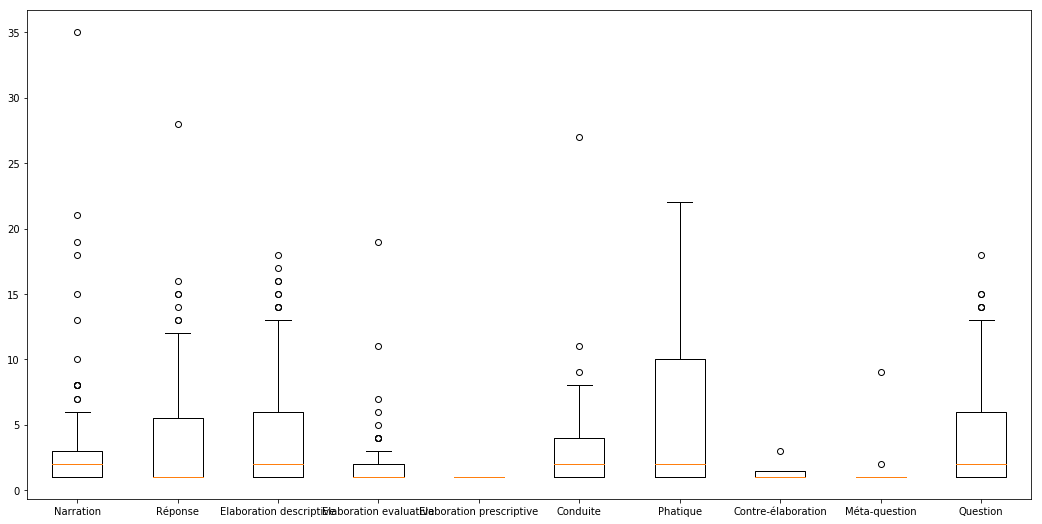

In [8]:
fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(111)
bp = ax.boxplot(relationsTotales.values())
ax.set_xticklabels(relationsTotales.keys())
plt.show()

Essayer de trier les unités par ordre d'entropie croissante et regarder quelles sont les relations majoritaires !

In [9]:
def rand_jitter(arr):
    """
    Ajoute un peu de bruit sur les données pour que les points ne soient pas tous superposés
    """
    stdev = .007*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev


def dessinerRelationsParEntropie(nomTexte, critere):
    """
    Dessine le graphe du nombre de chaque relation par unité, triées par entropie
    """
    x = listeEntropies[critere][nomTexte]
    trie = sorted(x.items(), key=operator.itemgetter(1))

    annotations = camp.getAnnotations(nomTexte)
    matriceTotale = annotations[0].matrice().copy()
    for a in annotations[1:]:
        matriceTotale = matriceTotale.add(a.matrice())
        
    fig, ax = plt.subplots(figsize=(18, 10))      
    colors=["red", "blue", "green", "yellow", "orange", "brown", "pink", "grey", "magenta", "tan"]

    relType = list()
    for i, rel in enumerate(camp.typesRelations):
        x = list()
        y = list()
        for origine, entropy in trie:
            x.append(entropy)
            y.append(matriceTotale[rel, origine].sum())
            relType.append(rel)
        ax.scatter(rand_jitter(x), rand_jitter(y), c=colors[i], label=rel)

    labels = ["{:.2f}".format(x[1])  + "\n"+ x[0] for x in trie]
    locs = [x[1] for x in trie]
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("Entropie")
    plt.ylabel("Nombre d'annotations")
    plt.show()

In [10]:
interact(dessinerRelationsParEntropie, nomTexte=camp.textes.keys(), critere=["type", "emplacement-type"])

interactive(children=(Dropdown(description='nomTexte', options=('Bac_a_sable', 'Florence', 'Provocation', 'Nor…

<function __main__.dessinerRelationsParEntropie(nomTexte, critere)>

## I.3 Clustering par texte

In [11]:
interact(clusteringParTexte, camp = fixed(camp), textname=camp.textes.keys(), critere = {"unité" : 0,"relation" : 1,"unité-relation" : 2})

interactive(children=(Dropdown(description='textname', options=('Bac_a_sable', 'Florence', 'Provocation', 'Nor…

<function analyse.clusteringParTexte(camp, textname, critere)>